In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the model
model = load_model(r'C:\Users\nitin\best_hair_disease_model.keras', custom_objects={'preprocess_input': preprocess_input})

# Path to full dataset folder (with class subfolders)
dataset_path = r"C:\Users\nitin\Desktop\hair_disease_data"  # your full dataset folder

# Create validation dataset from this folder
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% validation
    subset="validation",
    seed=123,  # set a seed for reproducibility
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

# Preprocess the images for EfficientNet
def preprocess(images, labels):
    images = preprocess_input(images)
    return images, labels

val_ds = val_ds.map(preprocess)

# Evaluate model on validation data
loss, acc = model.evaluate(val_ds)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}')


Found 4760 files belonging to 7 classes.
Using 952 files for validation.
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 646ms/step - accuracy: 0.9416 - loss: 0.1851
Validation Loss: 0.2909, Validation Accuracy: 0.9013


In [1]:
import os
import shutil
import random

def split_dataset(source_dir, train_dir, val_dir, val_ratio=0.2, seed=42):
    random.seed(seed)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    classes = [cls for cls in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, cls))]

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)
        
        split_index = int(len(images) * val_ratio)
        val_images = images[:split_index]
        train_images = images[split_index:]

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        for img in train_images:
            shutil.copy2(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
        for img in val_images:
            shutil.copy2(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

    print("Dataset split complete!")

# Example usage:
source = r"C:\Users\nitin\Desktop\hair_disease_data"
train_path = r"C:\Users\nitin\Desktop\hair_disease_data_split\train"
val_path = r"C:\Users\nitin\Desktop\hair_disease_data_split\val"

split_dataset(source, train_path, val_path)


Dataset split complete!


Found 952 files belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s

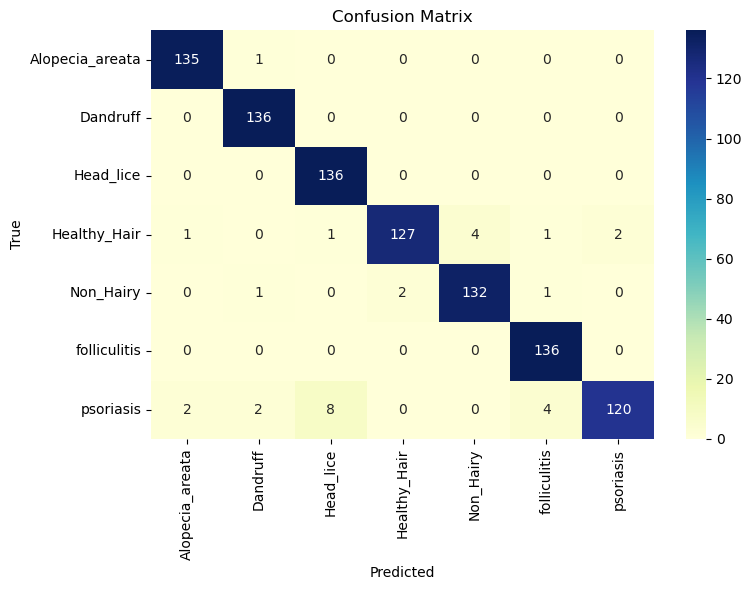


Overall Accuracy: 96.85%


In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# Load model
model = load_model(r'C:\Users\nitin\best_hair_disease_model.keras', custom_objects={'preprocess_input': preprocess_input})

# Paths to validation folder
val_dir = r"C:\Users\nitin\Desktop\hair_disease_data_split\val"

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

class_names = val_ds.class_names

# Preprocess images
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# Collect predictions and labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

# Print class-wise metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Optional: Accuracy
acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nOverall Accuracy: {acc * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


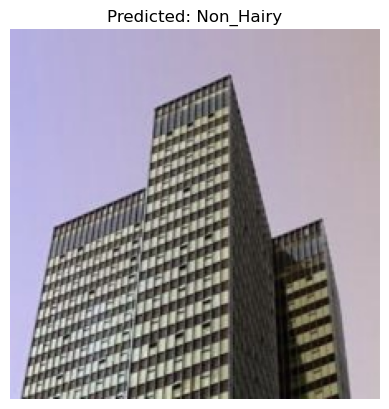

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ======== CONFIGURE ===========
model_path = r'C:\Users\nitin\best_hair_disease_model.keras'
image_path = r"C:\Users\nitin\Desktop\hair_disease_data\Non_Hairy\photo-1542361345-89e58247f2d5.jpg"# Change to your real image path
class_names = ['Alopecia_areata', 'Dandruff', 'Head_lice', 'Healthy_Hair', 'Non_Hairy', 'folliculitis', 'psoriasis']
# ==============================

# Load the model
model = load_model(model_path, custom_objects={'preprocess_input': preprocess_input})

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Load image and resize
    img_array = tf.keras.utils.img_to_array(img)                        # Convert to array
    img_array = np.expand_dims(img_array, axis=0)                      # Add batch dimension
    img_array = preprocess_input(img_array)                            # Apply EfficientNet preprocessing
    return img_array

# Predict
img_array = load_and_preprocess_image(image_path)
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Show image with predicted label
img_cv = cv2.imread(image_path)
img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv_rgb)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


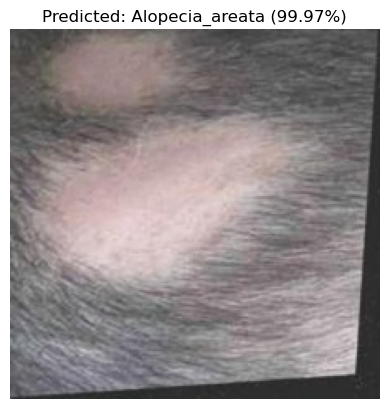


📢 Hair Disease Diagnosis Result
🧾 Predicted Disease : Alopecia_areata
✅ Confidence        : 99.97%

📌 Reason            : Caused by autoimmune disorder where immune system attacks hair follicles.
💊 Medicine          : Minoxidil 5%
📖 How to Use        : Apply 1mL twice daily on dry scalp. Do not rinse for 4 hours.
🩺 Solution Advice   : Topical corticosteroids, stress reduction, and healthy diet.

⚠️ Serious Case – Please consult:
👨‍⚕️ Dr. Neha Gupta, AIIMS Delhi, +91-9876543210



In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os

# ======== CONFIGURE ===========
model_path = r'C:\Users\nitin\best_hair_disease_model.keras'
image_path = r"C:\Users\nitin\Desktop\hair_disease_data\Alopecia_areata\alopecia_areata_0001_jpg.rf.f154d63c1f12aacb837bd9a40ffab710.jpg"
class_names = ['Alopecia_areata', 'Dandruff', 'Head_lice', 'Healthy_Hair', 'Non_Hairy', 'folliculitis', 'psoriasis']
knowledge_path = r"C:\Users\nitin\disease_knowledge.json.txt"  # Make sure this file is in the same directory
# ==============================

# Load the model
model = load_model(model_path, custom_objects={'preprocess_input': preprocess_input})

# Load disease knowledge base
def get_disease_info(disease_name):
    with open(knowledge_path, 'r') as f:
        knowledge = json.load(f)
    return knowledge.get(disease_name, {
        "cause": "Not available",
        "solution": "Not available",
        "medicine": "Not available",
        "usage": "Not available",
        "serious": False,
        "doctor": ""
    })

# Function to load and preprocess image
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Predict disease
img_array = load_and_preprocess_image(image_path)
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = np.max(predictions) * 100

# Get recommendation info
info = get_disease_info(predicted_class)

# Display image with label
img_cv = cv2.imread(image_path)
img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv_rgb)
plt.title(f'Predicted: {predicted_class} ({confidence:.2f}%)')
plt.axis('off')
plt.show()

# Print recommendation
print("\n📢 Hair Disease Diagnosis Result")
print("====================================")
print(f"🧾 Predicted Disease : {predicted_class}")
print(f"✅ Confidence        : {confidence:.2f}%")
print(f"\n📌 Reason            : {info['cause']}")
print(f"💊 Medicine          : {info['medicine']}")
print(f"📖 How to Use        : {info['usage']}")
print(f"🩺 Solution Advice   : {info['solution']}")
if info['serious']:
    print(f"\n⚠️ Serious Case – Please consult:")
    print(f"👨‍⚕️ {info['doctor']}")
print("====================================\n")


In [21]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\nitin


In [28]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import json

# Load your model and class names
model_path = r'C:\Users\nitin\best_hair_disease_model.keras'
model = load_model(model_path, custom_objects={'preprocess_input': preprocess_input})
class_names = ['Alopecia_areata', 'Dandruff', 'Head_lice', 'Healthy_Hair', 'Non_Hairy', 'folliculitis', 'psoriasis']

# Path to your recommendation JSON file
knowledge_path = r"C:\Users\nitin\disease_knowledge.json.txt"

def get_disease_info(disease_name):
    try:
        with open(knowledge_path, 'r') as f:
            knowledge = json.load(f)
        return knowledge.get(disease_name, {
            "cause": "Not available",
            "solution": "Not available",
            "medicine": "Not available",
            "usage": "Not available",
            "doctor": ""
        })
    except Exception:
        return {
            "cause": "Not available",
            "solution": "Not available",
            "medicine": "Not available",
            "usage": "Not available",
            "doctor": ""
        }

def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Tkinter GUI setup
root = tk.Tk()
root.title("Hair Disease Diagnosis & Recommendation System")
root.geometry("1920x1080")

# Variables
image_path_var = tk.StringVar()
gender_var = tk.StringVar(value="Male")

# Patient Info Frame
frame_info = tk.LabelFrame(root, text="Patient Information", padx=10, pady=10)
frame_info.grid(row=0, column=0, padx=10, pady=10, sticky="ew")

tk.Label(frame_info, text="Name:").grid(row=0, column=0, sticky="w")
entry_name = tk.Entry(frame_info, width=30)
entry_name.grid(row=0, column=1, pady=5)

tk.Label(frame_info, text="Age:").grid(row=1, column=0, sticky="w")
entry_age = tk.Entry(frame_info, width=30)
entry_age.grid(row=1, column=1, pady=5)

tk.Label(frame_info, text="Gender:").grid(row=2, column=0, sticky="w")
radio_male = tk.Radiobutton(frame_info, text="Male", variable=gender_var, value="Male")
radio_female = tk.Radiobutton(frame_info, text="Female", variable=gender_var, value="Female")
radio_male.grid(row=2, column=1, sticky="w")
radio_female.grid(row=2, column=1, sticky="e")

tk.Label(frame_info, text="Mobile No:").grid(row=3, column=0, sticky="w")
entry_mobile = tk.Entry(frame_info, width=30)
entry_mobile.grid(row=3, column=1, pady=5)

# Image Upload Frame
frame_image = tk.LabelFrame(root, text="Upload Hair Image", padx=10, pady=10)
frame_image.grid(row=1, column=0, padx=10, pady=10, sticky="ew")

label_image_path = tk.Label(frame_image, text="No file selected")
label_image_path.grid(row=0, column=0, padx=10)

def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if file_path:
        image_path_var.set(file_path)
        label_image_path.config(text=file_path)

btn_upload = tk.Button(frame_image, text="Upload Image", command=upload_image)
btn_upload.grid(row=0, column=1, padx=10)

# Result display label
result_label = tk.Label(root, text="", justify=tk.LEFT, font=("Arial", 12), fg="blue")
result_label.grid(row=3, column=0, padx=10, pady=10, sticky="w")

# Prediction and display function
def submit_action():
    name = entry_name.get().strip()
    age = entry_age.get().strip()
    gender = gender_var.get()
    mobile = entry_mobile.get().strip()
    image_path = image_path_var.get()

    # Validation
    if not (name and age and gender and mobile):
        messagebox.showerror("Input Error", "Please fill all patient details")
        return
    if not image_path:
        messagebox.showerror("Input Error", "Please upload an image")
        return
    try:
        age = int(age)
    except ValueError:
        messagebox.showerror("Input Error", "Age must be a number")
        return

    # Predict
    try:
        img_array = load_and_preprocess_image(image_path)
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions) * 100
    except Exception as e:
        messagebox.showerror("Prediction Error", f"Error during prediction:\n{e}")
        return

    info = get_disease_info(predicted_class)

    # Display results
    result_text = f"Disease: {predicted_class}\nConfidence: {confidence:.2f}%\n\n"
    result_text += f"Cause: {info['cause']}\nSolution: {info['solution']}\n\n"
    result_text += f"Medicine: {info['medicine']}\nUsage: {info['usage']}\n\n"
    if info['doctor']:
        result_text += f"Doctor Recommendation: {info['doctor']}"

    result_label.config(text=result_text)

# Submit button
btn_submit = tk.Button(root, text="Submit", width=20, command=submit_action)
btn_submit.grid(row=2, column=0, pady=10)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
import json

# Load model and knowledge base
model_path = 'best_hair_disease_model.keras'
model = load_model(model_path, custom_objects={'preprocess_input': preprocess_input})

with open(r'C:\Users\nitin\disease_knowledge.json.txt', 'r') as f:
    knowledge = json.load(f)

class_names = ['Alopecia_areata', 'Dandruff', 'Head_lice', 'Healthy_Hair', 'Non_Hairy', 'folliculitis', 'psoriasis']

# GUI
root = tk.Tk()
root.title("Hair Disease Diagnosis & Recommendation")
root.geometry("700x800")

# Patient Info Frame
frame_info = tk.Frame(root)
frame_info.grid(row=0, column=0, padx=10, pady=10)

tk.Label(frame_info, text="Name:").grid(row=0, column=0, sticky="w")
entry_name = tk.Entry(frame_info, width=30)
entry_name.grid(row=0, column=1)

tk.Label(frame_info, text="Age:").grid(row=1, column=0, sticky="w")
entry_age = tk.Entry(frame_info, width=30)
entry_age.grid(row=1, column=1)

tk.Label(frame_info, text="Gender:").grid(row=2, column=0, sticky="w")
gender_var = tk.StringVar()
gender_dropdown = tk.OptionMenu(frame_info, gender_var, "Male", "Female", "Other")
gender_dropdown.grid(row=2, column=1, sticky="w")


tk.Label(frame_info, text="Mobile No:").grid(row=3, column=0, sticky="w")
entry_mobile = tk.Entry(frame_info, width=30)
entry_mobile.grid(row=3, column=1)

# Image Upload Frame
frame_image = tk.Frame(root)
frame_image.grid(row=1, column=0, pady=10)

def upload_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if file_path:
        image_path_var.set(file_path)
        label_image_path.config(text=file_path)

        img = Image.open(file_path)
        img = img.resize((150, 150))
        img_tk = ImageTk.PhotoImage(img)
        image_preview_label.config(image=img_tk)
        image_preview_label.image = img_tk

image_path_var = tk.StringVar()
tk.Button(frame_image, text="📷 Upload Image", command=upload_image, bg="#e0f7fa", font=("Arial", 10, "bold")).grid(row=0, column=0, padx=5)
label_image_path = tk.Label(frame_image, text="No file selected", fg="gray")
label_image_path.grid(row=0, column=1)
image_preview_label = tk.Label(frame_image)
image_preview_label.grid(row=1, column=0, columnspan=2, pady=5)

# Status and Result Frame
status_label = tk.Label(root, text="", fg="green", font=("Arial", 10, "italic"))
status_label.grid(row=2, column=0)

result_box = tk.Text(root, height=15, width=90, wrap='word', font=("Arial", 11))
result_box.grid(row=3, column=0, padx=10, pady=10)

def display_result(text):
    result_box.delete(1.0, tk.END)
    result_box.insert(tk.END, text)

def submit_action():
    name = entry_name.get()
    age = entry_age.get()
    gender = gender_var.get()
    mobile = entry_mobile.get()
    image_path = image_path_var.get()

    if not (name and age and gender and mobile and image_path):
        messagebox.showwarning("Input Error", "Please fill all fields and upload image.")
        return

    status_label.config(text="Predicting... Please wait.")
    root.update()

    try:
        img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]
        confidence = np.max(predictions) * 100

        info = knowledge.get(predicted_class, {
            "cause": "Not available",
            "solution": "Not available",
            "medicine": "Not available",
            "usage": "Not available",
            "doctor": "Not available"
        })

        result_text = f"Patient Name: {name}\nAge: {age} | Gender: {gender} | Mobile: {mobile}\n\n"
        result_text += f"Predicted Disease: {predicted_class}\nConfidence: {confidence:.2f}%\n\n"
        result_text += f"Cause: {info['cause']}\n"
        result_text += f"Solution: {info['solution']}\n"
        result_text += f"Medicine: {info['medicine']}\n"
        result_text += f"How to Use: {info['usage']}\n"
        if info['doctor']:
            result_text += f"Consult Doctor: {info['doctor']}\n"

        display_result(result_text)
        status_label.config(text="Prediction complete!")

    except Exception as e:
        messagebox.showerror("Error", str(e))
        status_label.config(text="")

tk.Button(root, text="✅ Submit", width=20, command=submit_action, bg="#dcedc8", font=("Arial", 11, "bold")).grid(row=4, column=0, pady=5)

def clear_form():
    entry_name.delete(0, tk.END)
    entry_age.delete(0, tk.END)
    entry_mobile.delete(0, tk.END)
    gender_var.set("")
    image_path_var.set("")
    label_image_path.config(text="No file selected")
    image_preview_label.config(image="")
    result_box.delete(1.0, tk.END)
    status_label.config(text="")

def save_result_to_file():
    text = result_box.get(1.0, tk.END)
    if not text.strip():
        messagebox.showinfo("No Result", "No recommendation to save.")
        return
    file = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt")])
    if file:
        with open(file, 'w') as f:
            f.write(text)
        messagebox.showinfo("Saved", f"Report saved to {file}")

# Bottom Buttons
frame_bottom = tk.Frame(root)
frame_bottom.grid(row=5, column=0, pady=5)
tk.Button(frame_bottom, text="🧹 Clear Form", command=clear_form, bg="#ffe0b2").grid(row=0, column=0, padx=5)
tk.Button(frame_bottom, text="💾 Save Report", command=save_result_to_file, bg="#c5e1a5").grid(row=0, column=1, padx=5)

root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
